In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")
from clean_data import *
import os
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

# Methods
# Exploratory Data Analysis

Before building the model to explore the relation between salaries and the data feature, we did the Exploratory Data Analysis fisrly to have a intuitve sense about these features and whether they are related to the salaries. 


After crawling the data, we have 950 samples. Firstly, we noted that the salaries are in different forms, some are based on hour/year, and some are in a range such as 70-80 an hour, etc. Therefore, we cleaned up the salaries and converted them into salaries based on year.

In [3]:
job_salary = pd.read_csv("data.csv")
job_salary.salary

0      $36.45 - $43.04 an hour
1                  $43 an hour
2                  $28 an hour
3                  $46 an hour
4               $34.50 an hour
                ...           
945          $70 - $80 an hour
946            $120,000 a year
947             $40.35 an hour
948             $40.10 an hour
949                $35 an hour
Name: salary, Length: 950, dtype: object

In [4]:
job_salary = pd.read_csv("data.csv")
job_salary_cleaned = clean_requirements(job_salary)
job_salary_cleaned = convert_salary(job_salary)
job_salary_cleaned.salary

0      100157.4
1      108360.0
2       70560.0
3      115920.0
4       86940.0
         ...   
945    189000.0
946    120000.0
947    101682.0
948    101052.0
949     88200.0
Name: salary, Length: 950, dtype: float64

## Distribution of the salary



 We observed that most salaries are in from 50K to 100K, which agree with our intuitions. 

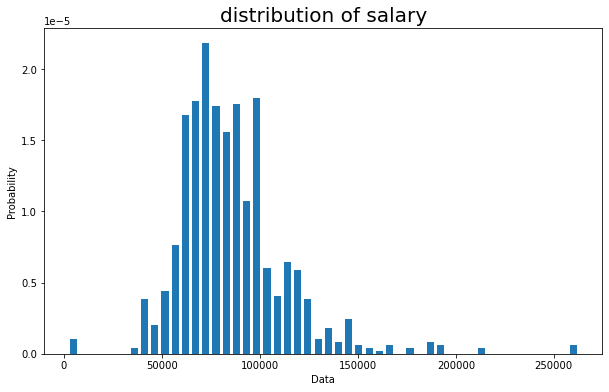

In [5]:
salary = job_salary_cleaned.salary.tolist()
plt.figure(figsize=(10,6))
plt.hist(salary,density=True, bins=50,rwidth=0.7)
plt.ylabel('Probability')
plt.xlabel('Data') 

plt.title('distribution of salary',fontsize =20) 


plt.show()

Next, We split the salaries into five ranges: <50K, 50-75K, 75-100K, 100-150K, >150K, which is for building our models.

In [6]:
# divide salary into 5 buckets
def salary_bucket(salary):
    if salary < 50000:
        return '<50,000'
    if salary >= 50000 and salary < 75000:
        return '50,000-75,000'
    elif salary >= 75000 and salary < 100000:
        return '75,000-100,000'
    elif salary >=100000 and salary <= 150000:
        return '10,0000-15,0000'
    else:
        return '>150,000'
    
job_salary_cleaned['salary_buckets'] = job_salary_cleaned['salary'].apply(lambda x: salary_bucket(x))

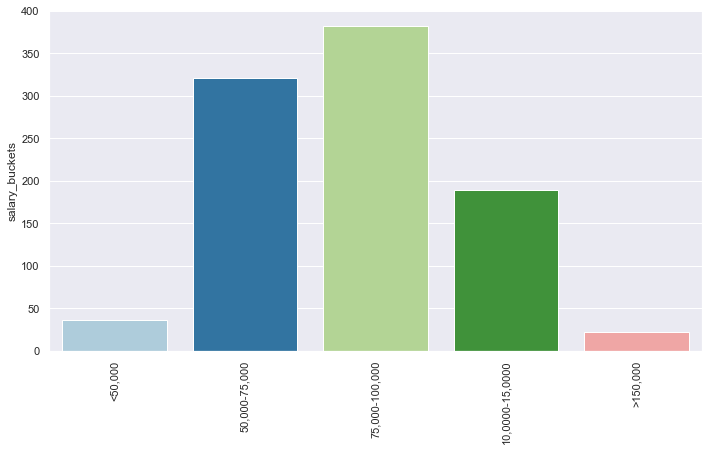

In [7]:
buckets_count = job_salary_cleaned['salary_buckets'].value_counts()
# distribution of classes
# [3, 1, 0, 2, 4] is used to list classes in ascending order
sns.set(rc={'figure.figsize':(11.7,6.27)}) 
sns.barplot(x=buckets_count.index[[3,1,0,2,4]], y=buckets_count[[3,1,0,2,4]], palette="Paired")
plt.xticks(rotation=90)
plt.show()

## Preliminary analysis

Before builing the models, we would like to have a preliminary analysis on the feautres.

In particular, we want to have some sense about how these features affect the salary by just doing some basic visualization.

### Location feature

For each province, and city. We calcuted the average salaries. We can observed that in each province, the average salary is different. ON and BC have higher salaries than other province. And the average salary of remote jobs is the highest.

However, the difference among different province is not very obvious. Instead, we looked at the average salary on each city. The difference is now obvious, some cities has avg salary higher than 100K, and some others are lower than 60K.




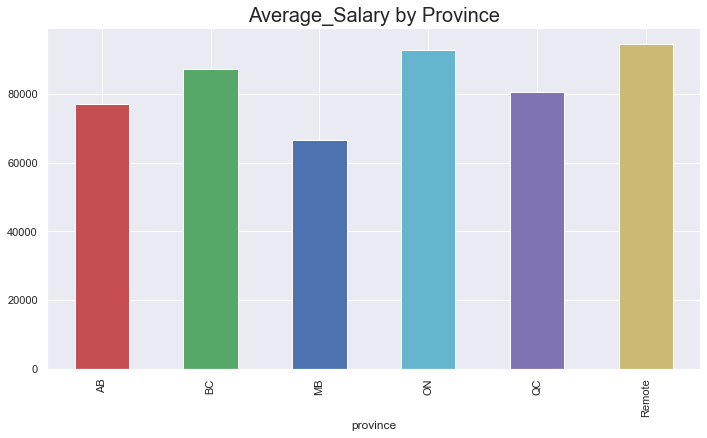

In [8]:
data = job_salary_cleaned
data = clean_location(data)
my_colors = 'rgbcmyk' 
mean_salary = data.groupby(['province']).mean()
mean_salary.plot(kind='bar',color=my_colors,legend=False)
plt.title("Average_Salary by Province", fontsize =20)
plt.show()

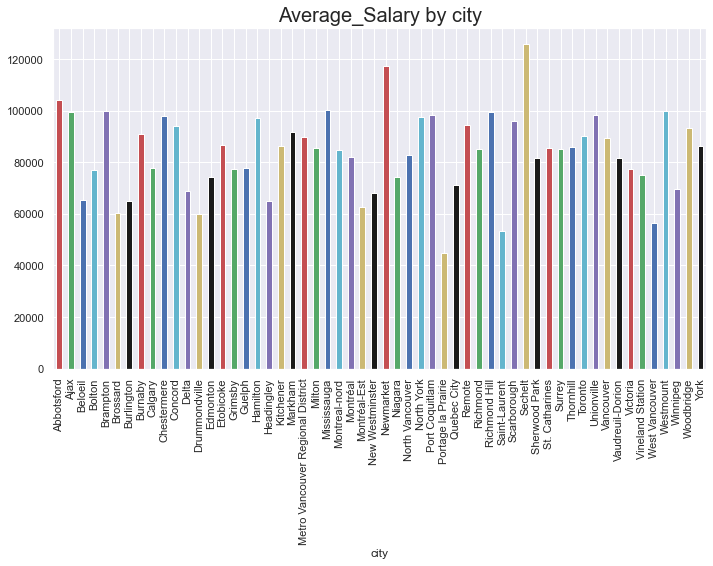

In [9]:
mean_salary = data.groupby(['city']).mean()
mean_salary.plot(kind='bar',color=my_colors,legend=False)
plt.title("Average_Salary by city", fontsize =20)
plt.show()

### Job requirements feature



In order to extract features from requirement text. We need a nature language processing (NLP) method to handle with text data. Term frequency-inverse document frequency (TF-IDF) is one of popular NLP methods. It can reflect how important a word is to a document in a corpus. Compared to bag of words, another popular NLP method, TF-IDF reduces the importance of some frequently occurring terms like we, need or have which may not be included in stop words. If a term appears in every observation, it has no contribution to the model. Thus, we decided to use TF-IDF to extract features. In python, sklearn library has a function called TFidfVectorizer. It can calculate TF-IDF of terms in each document. Because some bigrams like machine learning or deep learning may be important to predict the salary, we extracted both unigram and bigram at the same time, and we only selected top 1,000 features. Because we only have 1000 data, if we included all features, the dimension of the data will be too large. 

The following two images show top 50 words in selected features. 

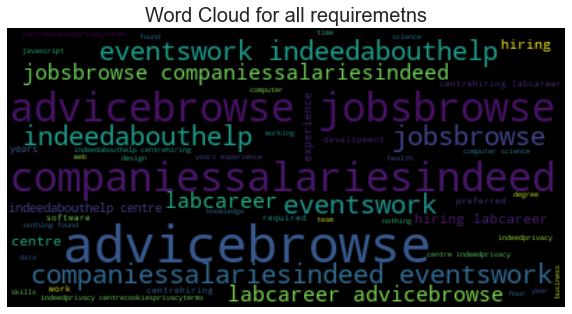

In [11]:
# extract features
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
corpus = data['requirements_cleaned'].values
grams = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names()
words_df = pd.DataFrame(grams.toarray(), columns=feature_names)

amount = words_df.sum(axis=0)
top50 = amount.nlargest(50)
df = top50.to_frame().reset_index()
df.columns = ['word', 'count']
words = dict(zip(df['word'].tolist(), df['count'].tolist()))

wc = WordCloud().generate_from_frequencies(words)

plt.figure(figsize=(10, 10))
plt.imshow(wc,interpolation='bilinear')
plt.title("Word Cloud for all requiremetns", fontsize=20)
plt.axis('off')
plt.show()

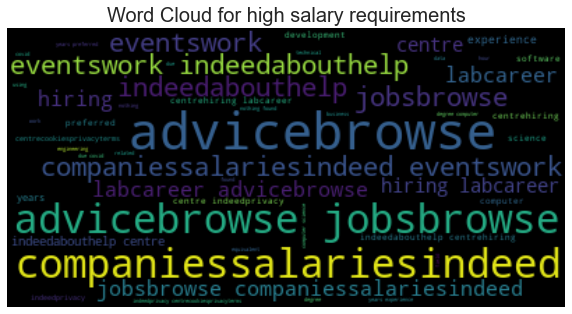

In [13]:
high_salary = data.loc[data['salary'] >100000]
# extract features
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
corpus = high_salary['requirements_cleaned'].values
grams = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names()
words_df = pd.DataFrame(grams.toarray(), columns=feature_names)

amount = words_df.sum(axis=0)
top50 = amount.nlargest(50)
df = top50.to_frame().reset_index()
df.columns = ['word', 'count']
words = dict(zip(df['word'].tolist(), df['count'].tolist()))
wc = WordCloud().generate_from_frequencies(words)

plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.title("Word Cloud for high salary requirements", fontsize=20)
plt.axis('off')
plt.show()

They are pretty similar no matter if the condition salary > 10K is added or not. The words like advicebrowse, companiessalariesindeed, eventswork have large overall TF-IDF values in corpus but they don’t make any sense for job hunters. In this case, we need to build the models to explore the relationship between features and salary.

### Category feature
In the data crawling step, we crawled salaries for 5 different job categories. and we see that at the current time, most jobs are still about software and development.

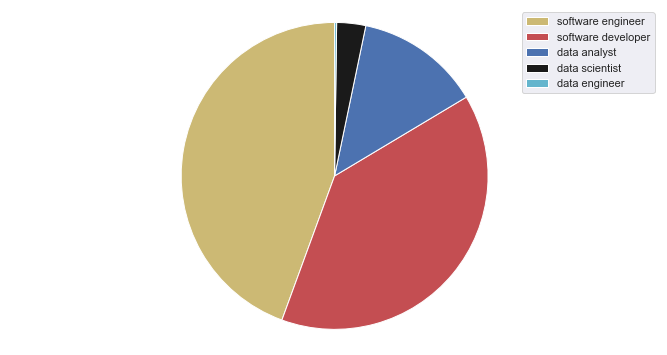

In [11]:
category = pd.DataFrame(job_salary['job_category'].value_counts()).reset_index()
category.columns = ['category', 'amount']
cat = category['category'] ; amount = category['amount']
colors = 'yrbkc' 

explode = (0, 0, 0, 0, 0)  
wedges, texts = plt.pie(amount, colors = colors, startangle=90, explode=explode)
plt.axis('equal') 
plt.legend(wedges, cat, loc="best")
plt.show()


Since there are not many examples of the job such as data scientist and data engineer, it is not very useful to compare the mean salary of different category, but from the scatter plots, we can still realize that most jobs from different categories are in the similar range.

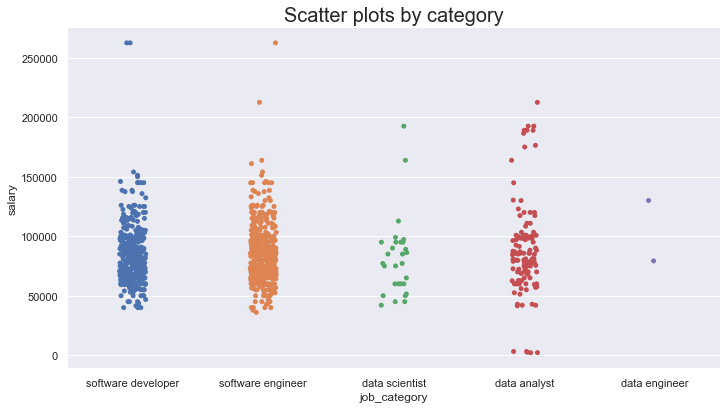

In [15]:
sns.stripplot(x="job_category", y="salary", data=job_salary_cleaned) 
plt.title("Scatter plots by category", fontsize=20)
plt.show()